<a href="https://colab.research.google.com/github/hubertdomagalaa/Chat_financial_advisor/blob/main/Licencjat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Basic Data Manipulation and Analysis
import pandas as pd              # For data manipulation and analysis
import numpy as np              # For numerical operations

# Data Visualization
import matplotlib.pyplot as plt  # Basic plotting library
import seaborn as sns           # Statistical data visualization
     # Set the plotting style

!pip install ta
# Technical Analysis
                    # Technical analysis library
import ta
from ta.trend import SMAIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands

# Machine Learning
from sklearn.model_selection import train_test_split  # For splitting dataset
from sklearn.preprocessing import StandardScaler      # For feature scaling
from sklearn.linear_model import LogisticRegression  # Our main model
from sklearn.ensemble import (
    RandomForestClassifier,     # Alternative model option
    GradientBoostingClassifier  # Alternative model option
)

# Model Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc
)

# Date and Time handling
from datetime import datetime, timedelta

# Data Download (if needed)
import yfinance as yf           # For downloading stock data from Yahoo Finance

# System utilities
import os                       # For file and directory operations
import warnings                 # For handling warning messages
warnings.filterwarnings('ignore')  # Suppress warnings

# For data persistence
import joblib                   # For saving/loading models

# For progress tracking
from tqdm import tqdm           # For progress bars

In [ ]:
final_df = pd.read_csv('/content/BTC_USD_2y_dataset.csv')

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
import datetime
import traceback

def get_complete_dataset(symbol='BTC-USD', period='2y', save_excel=True):
    """
    Get complete dataset with all features and save to Excel with descriptions
    """
    try:
        # Fetch data with error checking
        print(f"Fetching {symbol} data for {period} period...")
        crypto = yf.Ticker(symbol)
        df = crypto.history(period=period)

        if df.empty:
            raise ValueError(f"No data retrieved for {symbol}")

        print(f"Retrieved {len(df)} rows of data")
        print("Initial columns:", df.columns.tolist())

        # Reset index and handle timezone
        df.reset_index(inplace=True)
        df['Date'] = pd.to_datetime(df['Date']).dt.tz_localize(None)

        print("Computing technical indicators...")

        # Store intermediate results for debugging
        results = {}

        # Basic price and volume calculations
        try:
            results['sma'] = ta.trend.sma_indicator(df['Close'], window=5)
            df['SMA_5'] = results['sma']
            df['SMA_20'] = ta.trend.sma_indicator(df['Close'], window=20)
            df['EMA_12'] = ta.trend.ema_indicator(df['Close'], window=12)
            df['EMA_26'] = ta.trend.ema_indicator(df['Close'], window=26)
            print("Basic indicators computed successfully")
        except Exception as e:
            print(f"Error in basic indicators: {str(e)}")
            raise

        # RSI
        try:
            df['RSI'] = ta.momentum.rsi(df['Close'], window=14)
            print("RSI computed successfully")
        except Exception as e:
            print(f"Error in RSI: {str(e)}")
            raise

        # MACD
        try:
            macd = ta.trend.MACD(df['Close'])
            df['MACD'] = macd.macd()
            df['MACD_signal'] = macd.macd_signal()
            df['MACD_diff'] = macd.macd_diff()
            print("MACD computed successfully")
        except Exception as e:
            print(f"Error in MACD: {str(e)}")
            raise

        # Bollinger Bands
        try:
            bollinger = ta.volatility.BollingerBands(df['Close'])
            df['BB_high'] = bollinger.bollinger_hband()
            df['BB_low'] = bollinger.bollinger_lband()
            df['BB_mid'] = bollinger.bollinger_mavg()
            df['BB_width'] = (df['BB_high'] - df['BB_low']) / df['BB_mid']
            print("Bollinger Bands computed successfully")
        except Exception as e:
            print(f"Error in Bollinger Bands: {str(e)}")
            raise

        # Additional indicators
        try:
            df['ROC'] = ta.momentum.roc(df['Close'], window=12)
            df['Stoch_K'] = ta.momentum.stoch(df['High'], df['Low'], df['Close'])
            df['Stoch_D'] = ta.momentum.stoch_signal(df['High'], df['Low'], df['Close'])
            df['ATR'] = ta.volatility.average_true_range(df['High'], df['Low'], df['Close'])
            df['OBV'] = ta.volume.on_balance_volume(df['Close'], df['Volume'])
            print("Additional indicators computed successfully")
        except Exception as e:
            print(f"Error in additional indicators: {str(e)}")
            raise

        # Price and volume changes
        try:
            df['Volume_SMA_5'] = ta.trend.sma_indicator(df['Volume'], window=5)
            df['Volume_Change'] = df['Volume'].pct_change()
            df['Price_Change'] = df['Close'].pct_change()
            df['Price_Change_5'] = df['Close'].pct_change(periods=5)
            df['Volatility'] = df['Close'].pct_change().rolling(window=20).std()
            print("Changes and volatility computed successfully")
        except Exception as e:
            print(f"Error in changes calculation: {str(e)}")
            raise

        # Trend and regime
        try:
            df['Trend'] = np.where(df['SMA_5'] > df['SMA_20'], 1, -1)
            df['Volatility_Mean'] = df['Volatility'].rolling(window=20).mean()
            df['Regime'] = np.where(
                (df['Volatility'] > df['Volatility_Mean']) & (df['Trend'] == 1),
                'High_Vol_Uptrend',
                np.where(
                    (df['Volatility'] > df['Volatility_Mean']) & (df['Trend'] == -1),
                    'High_Vol_Downtrend',
                    np.where(
                        (df['Volatility'] <= df['Volatility_Mean']) & (df['Trend'] == 1),
                        'Low_Vol_Uptrend',
                        'Low_Vol_Downtrend'
                    )
                )
            )
            print("Trend and regime computed successfully")
        except Exception as e:
            print(f"Error in trend calculation: {str(e)}")
            raise

        # Target variable
        df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

        # Clean up the data
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df.dropna()

        # Round numerical columns
        numeric_columns = df.select_dtypes(include=[np.number]).columns
        df[numeric_columns] = df[numeric_columns].round(6)

        print("\nFinal dataset shape:", df.shape)
        print("Final columns:", df.columns.tolist())

        if save_excel:
            try:
                filename = f"{symbol.replace('-', '_')}_{period}_dataset.csv"
                df.to_csv(filename, index=False)
                print(f"\nDataset saved to {filename}")
            except Exception as e:
                print(f"Error saving to file: {str(e)}")

        return df

    except Exception as e:
        print("\nError in data preparation:")
        print(str(e))
        traceback.print_exc()
        return None

# Example usage
if __name__ == "__main__":
    try:
        # Get data
        final_df = get_complete_dataset(symbol='BTC-USD', period='2y')

        if final_df is not None:
            print("\nDataset Preview:")
            print(final_df.head())

            print("\nData Types:")
            print(final_df.dtypes)

            print("\nBasic Statistics:")
            print(final_df.describe())
        else:
            print("Failed to create dataset")

    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        traceback.print_exc()


Fetching BTC-USD data for 2y period...
Retrieved 732 rows of data
Initial columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
Computing technical indicators...
Basic indicators computed successfully
RSI computed successfully
MACD computed successfully
Bollinger Bands computed successfully
Additional indicators computed successfully
Changes and volatility computed successfully
Trend and regime computed successfully

Final dataset shape: (693, 34)
Final columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'SMA_5', 'SMA_20', 'EMA_12', 'EMA_26', 'RSI', 'MACD', 'MACD_signal', 'MACD_diff', 'BB_high', 'BB_low', 'BB_mid', 'BB_width', 'ROC', 'Stoch_K', 'Stoch_D', 'ATR', 'OBV', 'Volume_SMA_5', 'Volume_Change', 'Price_Change', 'Price_Change_5', 'Volatility', 'Trend', 'Volatility_Mean', 'Regime', 'Target']

Dataset saved to BTC_USD_2y_dataset.csv

Dataset Preview:
         Date          Open          High           Low         Close 

In [ ]:
final_df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_5,SMA_20,...,OBV,Volume_SMA_5,Volume_Change,Price_Change,Price_Change_5,Volatility,Trend,Volatility_Mean,Regime,Target
0,20/01/2023,21085.37305,22692.35742,20919.12695,22676.55273,2.879915e+10,0,0,21356.65586,18734.44287,...,1.890600e+11,2.635002e+10,0.361479,0.075391,0.086000,0.024573,1,0.014636,High_Vol_Uptrend,1
1,21/01/2023,22677.42773,23282.34766,22511.83398,22777.62500,3.244228e+10,0,0,21678.25430,19042.07012,...,2.215030e+11,2.747998e+10,0.126501,0.004457,0.075957,0.024579,1,0.015051,High_Vol_Uptrend,0
2,22/01/2023,22777.98633,23056.73047,22387.90039,22720.41602,2.474639e+10,0,0,21990.03359,19343.66738,...,1.967560e+11,2.742926e+10,-0.237218,-0.002512,0.073667,0.024786,1,0.015583,High_Vol_Uptrend,1
3,23/01/2023,22721.08789,23126.48633,22654.30469,22934.43164,2.651870e+10,0,0,22439.16367,19656.39609,...,2.232750e+11,2.673187e+10,0.071619,0.009420,0.108544,0.024539,1,0.016105,High_Vol_Uptrend,0
4,24/01/2023,22929.62695,23134.01172,22549.74414,22636.46875,2.640507e+10,0,0,22749.09883,19945.05762,...,1.968700e+11,2.778232e+10,-0.004285,-0.012992,0.073490,0.025385,1,0.016703,High_Vol_Uptrend,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,08/12/2024,99921.91406,101399.99220,98771.51563,101236.01560,4.412575e+10,0,0,99288.43281,96808.96953,...,9.429930e+11,8.185136e+10,-0.001172,0.013137,0.054518,0.023252,1,0.030122,Low_Vol_Uptrend,0
689,09/12/2024,101237.06250,101272.50780,94355.91406,97432.71875,1.106760e+11,0,0,99021.27031,97063.41602,...,8.323160e+11,8.854669e+10,1.508206,-0.037569,-0.013525,0.024916,1,0.029581,Low_Vol_Uptrend,0
690,10/12/2024,97441.23438,98270.15625,94321.25781,96675.42969,1.048240e+11,0,0,99037.64219,97180.21289,...,7.274930e+11,7.966766e+10,-0.052881,-0.007772,0.000847,0.024624,1,0.029094,Low_Vol_Uptrend,1
691,11/12/2024,96656.06250,101913.35940,95747.22656,101173.03130,8.539141e+10,0,0,99288.10625,97313.62813,...,8.128840e+11,7.783899e+10,-0.185381,0.046523,0.012533,0.024845,1,0.028618,Low_Vol_Uptrend,1


In [ ]:
import pandas as pd

# Assuming 'final_df' is your DataFrame
# Replace 'final_output.xlsx' with your desired file name

output_filename = 'final_output.xlsx'

# Export the DataFrame to an Excel file
final_df.to_excel(output_filename, index=False)  # Set index=True if you want to include the DataFrame index

print(f"DataFrame has been written to {output_filename}")


DataFrame has been written to final_output.xlsx


First 5 rows of the dataset:
        Date         Open         High          Low        Close  \
0 2023-01-20  21085.37305  22692.35742  20919.12695  22676.55273   
1 2023-01-21  22677.42773  23282.34766  22511.83398  22777.62500   
2 2023-01-22  22777.98633  23056.73047  22387.90039  22720.41602   
3 2023-01-23  22721.08789  23126.48633  22654.30469  22934.43164   
4 2023-01-24  22929.62695  23134.01172  22549.74414  22636.46875   

         Volume  Dividends  Stock Splits        SMA_5       SMA_20  ...  \
0  2.879915e+10          0             0  21356.65586  18734.44287  ...   
1  3.244228e+10          0             0  21678.25430  19042.07012  ...   
2  2.474639e+10          0             0  21990.03359  19343.66738  ...   
3  2.651870e+10          0             0  22439.16367  19656.39609  ...   
4  2.640507e+10          0             0  22749.09883  19945.05762  ...   

            OBV  Volume_SMA_5  Volume_Change  Price_Change  Price_Change_5  \
0  1.890600e+11  2.635002e+10    

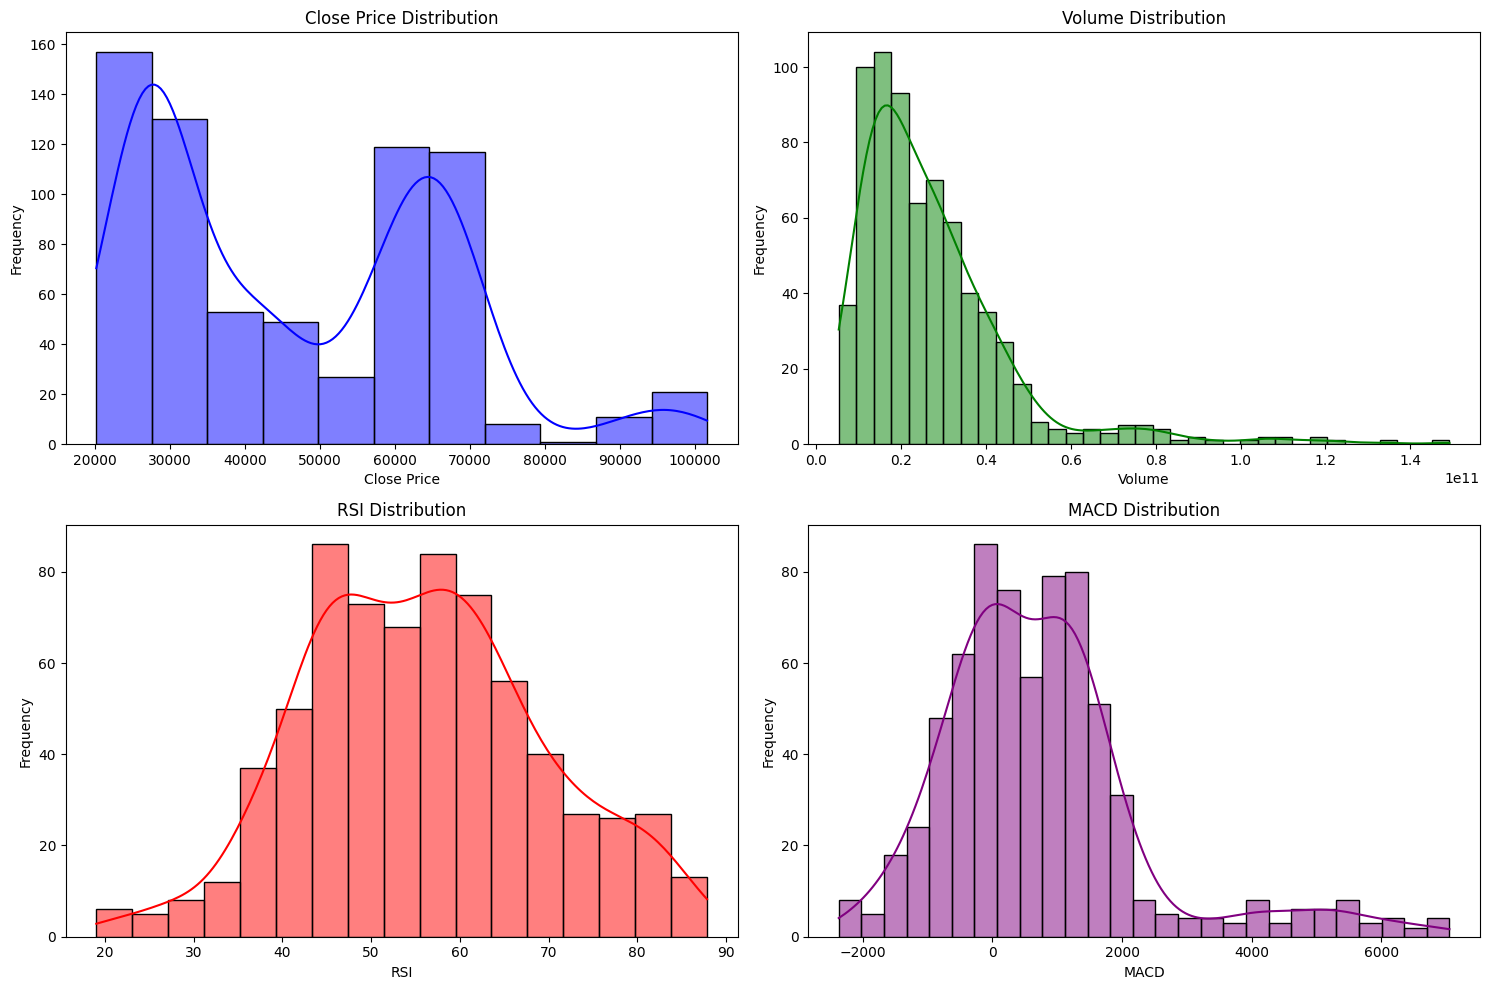

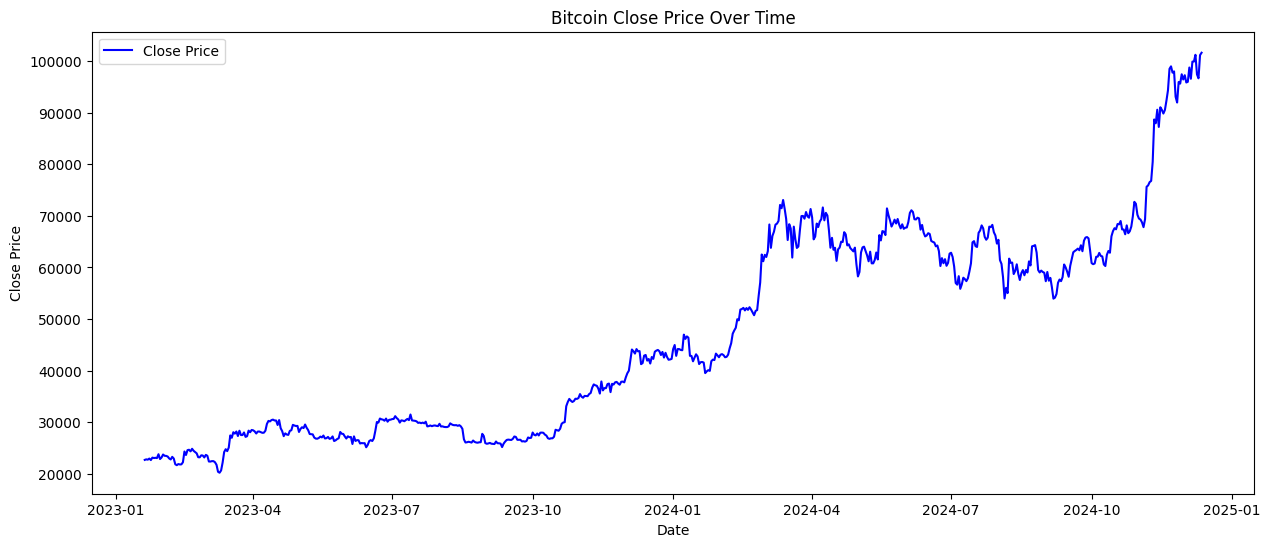

Skewness of Close Price: 0.5597135195180909
Kurtosis of Close Price: -0.6040937195167815


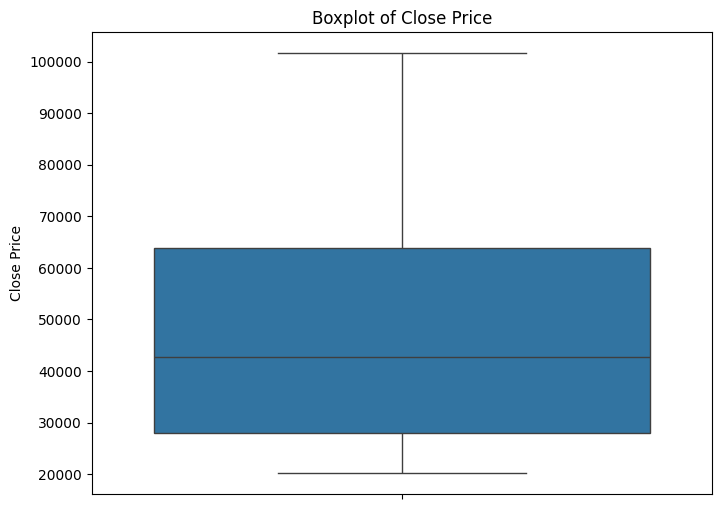

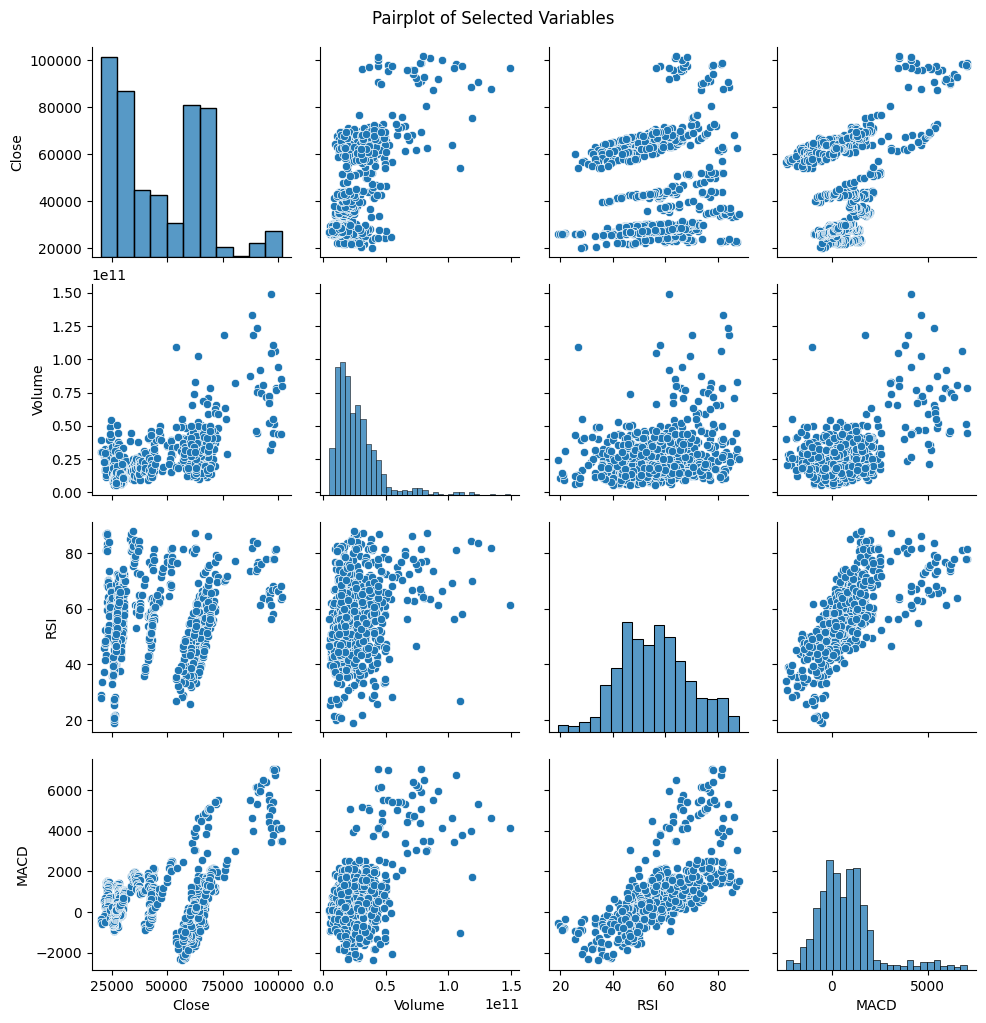

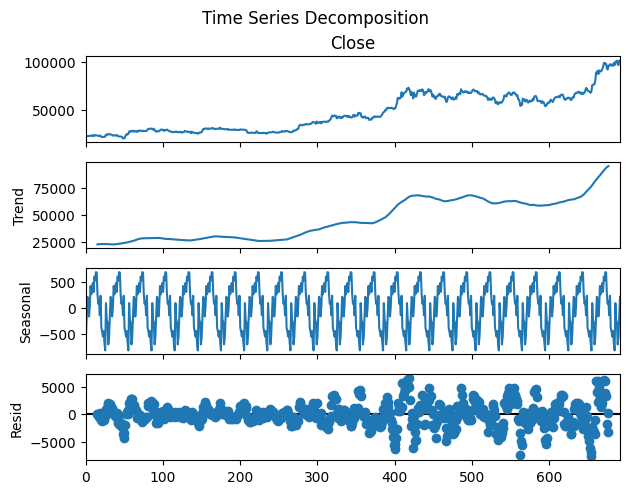

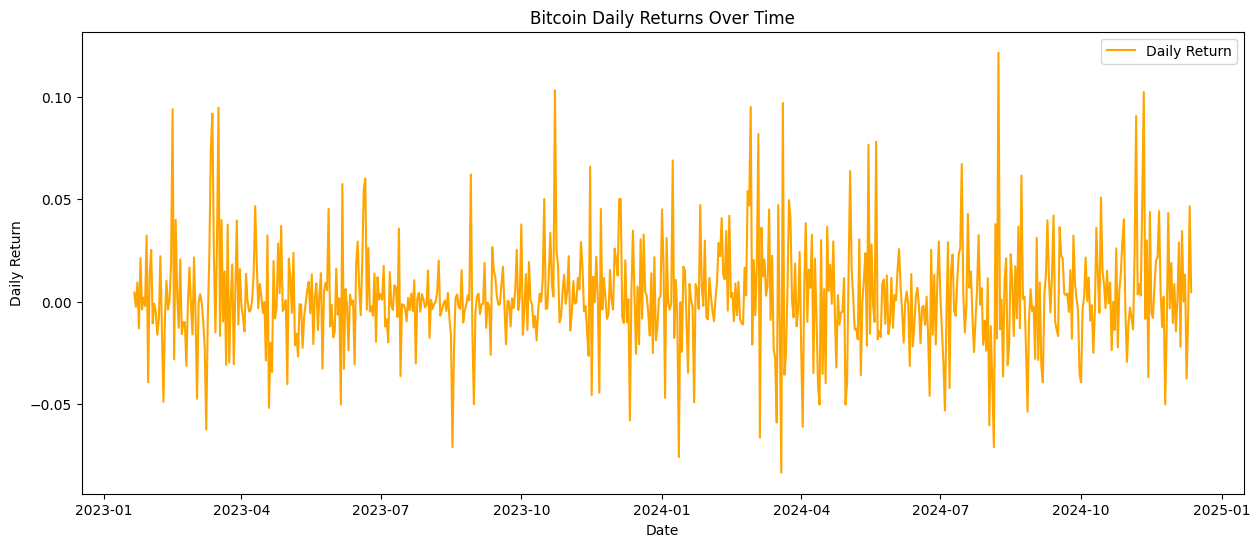

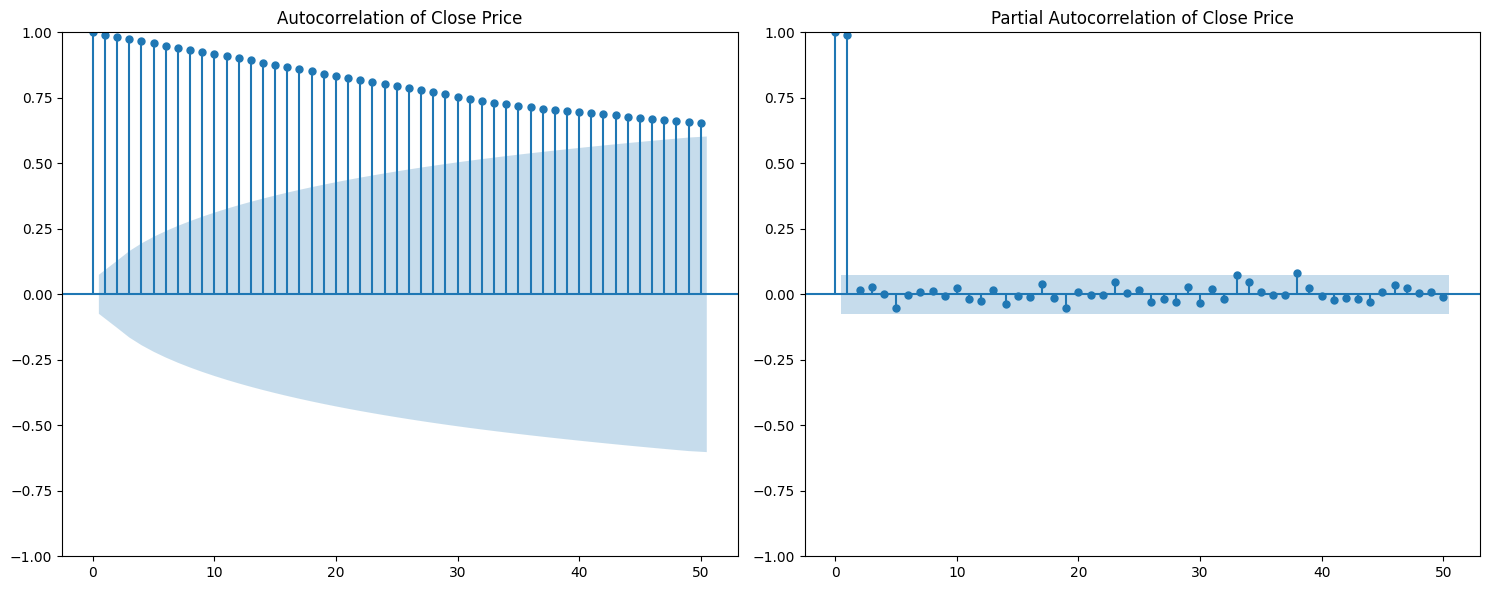

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Step 1: Basic Data Overview
# ---------------------------
# Display the first few rows of the dataset
print("First 5 rows of the dataset:")
print(final_df.head())

# Basic statistics for numerical columns
print("\nBasic statistics for numerical columns:")
print(final_df.describe())

# Check for missing values
print("\nMissing values in each column:")
print(final_df.isnull().sum())

# Check data types of each column
print("\nData types of each column:")
print(final_df.dtypes)

# Step 2: Visualize Distributions of Key Variables
# -----------------------------------------------
plt.figure(figsize=(15, 10))

# Close Price Distribution
plt.subplot(2, 2, 1)
sns.histplot(final_df['Close'], kde=True, color='blue')
plt.title('Close Price Distribution')
plt.xlabel('Close Price')
plt.ylabel('Frequency')

# Volume Distribution
plt.subplot(2, 2, 2)
sns.histplot(final_df['Volume'], kde=True, color='green')
plt.title('Volume Distribution')
plt.xlabel('Volume')
plt.ylabel('Frequency')

# RSI Distribution
plt.subplot(2, 2, 3)
sns.histplot(final_df['RSI'], kde=True, color='red')
plt.title('RSI Distribution')
plt.xlabel('RSI')
plt.ylabel('Frequency')

# MACD Distribution
plt.subplot(2, 2, 4)
sns.histplot(final_df['MACD'], kde=True, color='purple')
plt.title('MACD Distribution')
plt.xlabel('MACD')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Step 3: Time Series Analysis
# ----------------------------
# Convert 'Date' column to datetime format
final_df['Date'] = pd.to_datetime(final_df['Date'], format='%d/%m/%Y')

# Plot Close Price over Time
plt.figure(figsize=(15, 6))
plt.plot(final_df['Date'], final_df['Close'], label='Close Price', color='blue')
plt.title('Bitcoin Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


# Step 5: Additional Variable Checks
# ----------------------------------
# Skewness and Kurtosis of Close Price
print("Skewness of Close Price:", skew(final_df['Close']))
print("Kurtosis of Close Price:", kurtosis(final_df['Close']))

# Boxplot for Close Price
plt.figure(figsize=(8, 6))
sns.boxplot(y=final_df['Close'])
plt.title('Boxplot of Close Price')
plt.ylabel('Close Price')
plt.show()

# Pairplot for selected variables
sns.pairplot(final_df[['Close', 'Volume', 'RSI', 'MACD']])
plt.suptitle('Pairplot of Selected Variables', y=1.02)
plt.show()

# Step 6: Trend and Seasonality Analysis
# --------------------------------------
# Decompose the time series to observe trend, seasonality, and residuals
decomposition = seasonal_decompose(final_df['Close'], model='additive', period=30)
decomposition.plot()
plt.suptitle('Time Series Decomposition', y=1.02)
plt.show()

# Step 7: Volatility Analysis
# ---------------------------
# Calculate daily returns
final_df['Daily_Return'] = final_df['Close'].pct_change()

# Plot daily returns
plt.figure(figsize=(15, 6))
plt.plot(final_df['Date'], final_df['Daily_Return'], label='Daily Return', color='orange')
plt.title('Bitcoin Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()

# Step 8: Advanced Analysis (Optional)
# ------------------------------------
# Autocorrelation and Partial Autocorrelation for Close Price
plt.figure(figsize=(15, 6))

# Autocorrelation
plt.subplot(1, 2, 1)
plot_acf(final_df['Close'], lags=50, ax=plt.gca())
plt.title('Autocorrelation of Close Price')

# Partial Autocorrelation
plt.subplot(1, 2, 2)
plot_pacf(final_df['Close'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation of Close Price')

plt.tight_layout()
plt.show()

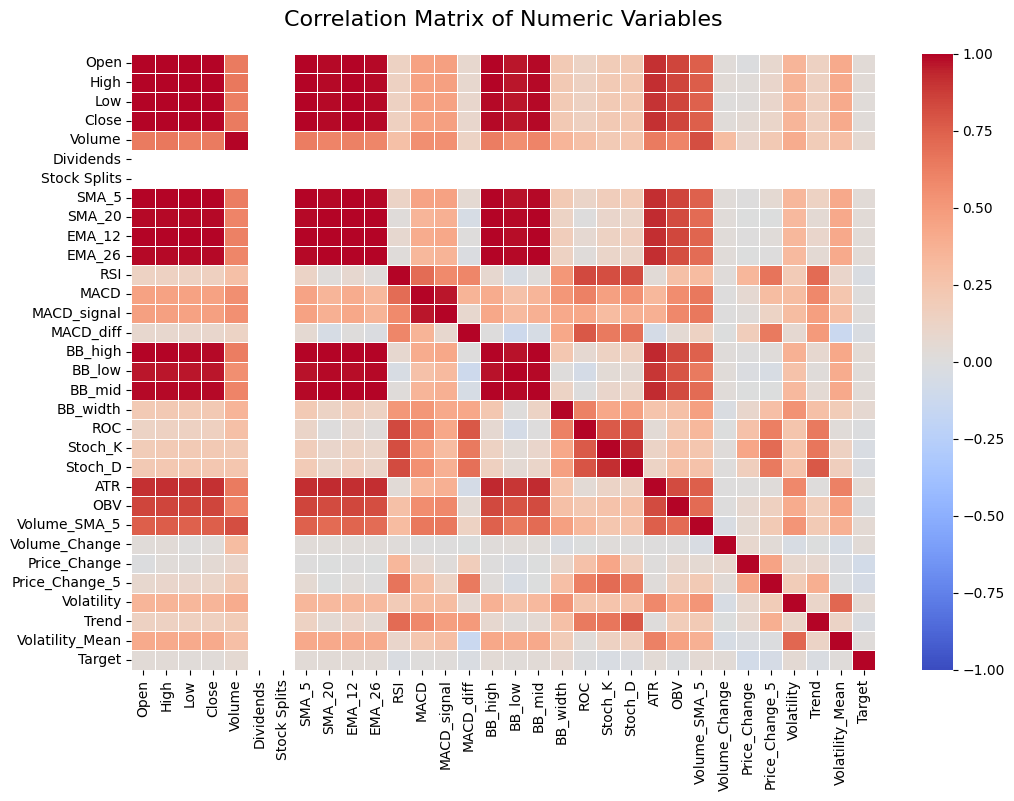

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the dataset (assuming final_df is already loaded)
# If not loaded, use: final_df = pd.read_csv('your_dataset.csv')

# Step 2: Filter numeric columns for correlation matrix
# ---------------------------------------
# Select only numeric columns (e.g., float, int)
numeric_df = final_df.select_dtypes(include=['float64', 'int64'])

# Step 3: Calculate the correlation matrix
# ---------------------------------------
# The .corr() function computes pairwise correlation of numeric columns
corr_matrix = numeric_df.corr()

# Step 4: Plot the correlation matrix using Seaborn's heatmap
# -----------------------------------------------------------
plt.figure(figsize=(12, 8))  # Set the figure size

# Create the heatmap
sns.heatmap(
    corr_matrix,        # Correlation matrix data
    annot=False,         # Annotate the heatmap with correlation values
    cmap='coolwarm',    # Color map for the heatmap
    fmt='.2f',          # Format for the annotations (2 decimal places)
    linewidths=0.5,     # Add lines between cells
    vmin=-1, vmax=1     # Set the range for the color scale (-1 to 1 for correlations)
)

# Add a title
plt.title('Correlation Matrix of Numeric Variables', fontsize=16, pad=20)

# Display the plot
plt.show()

# JAKO TAKO TO WYGLĄDA 29/12/2024


Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0403
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0051
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0027
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0021
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0015
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0014
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0015
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0014
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0012
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0010
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.7106e-04
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 8.3208e-04
Epoch 13/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 7.6884e-04
Epoch 14/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 7.9785e-04
Epoch 15/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - l

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4zsberfa/4ovl_cfe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4zsberfa/x1jb_wxf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads

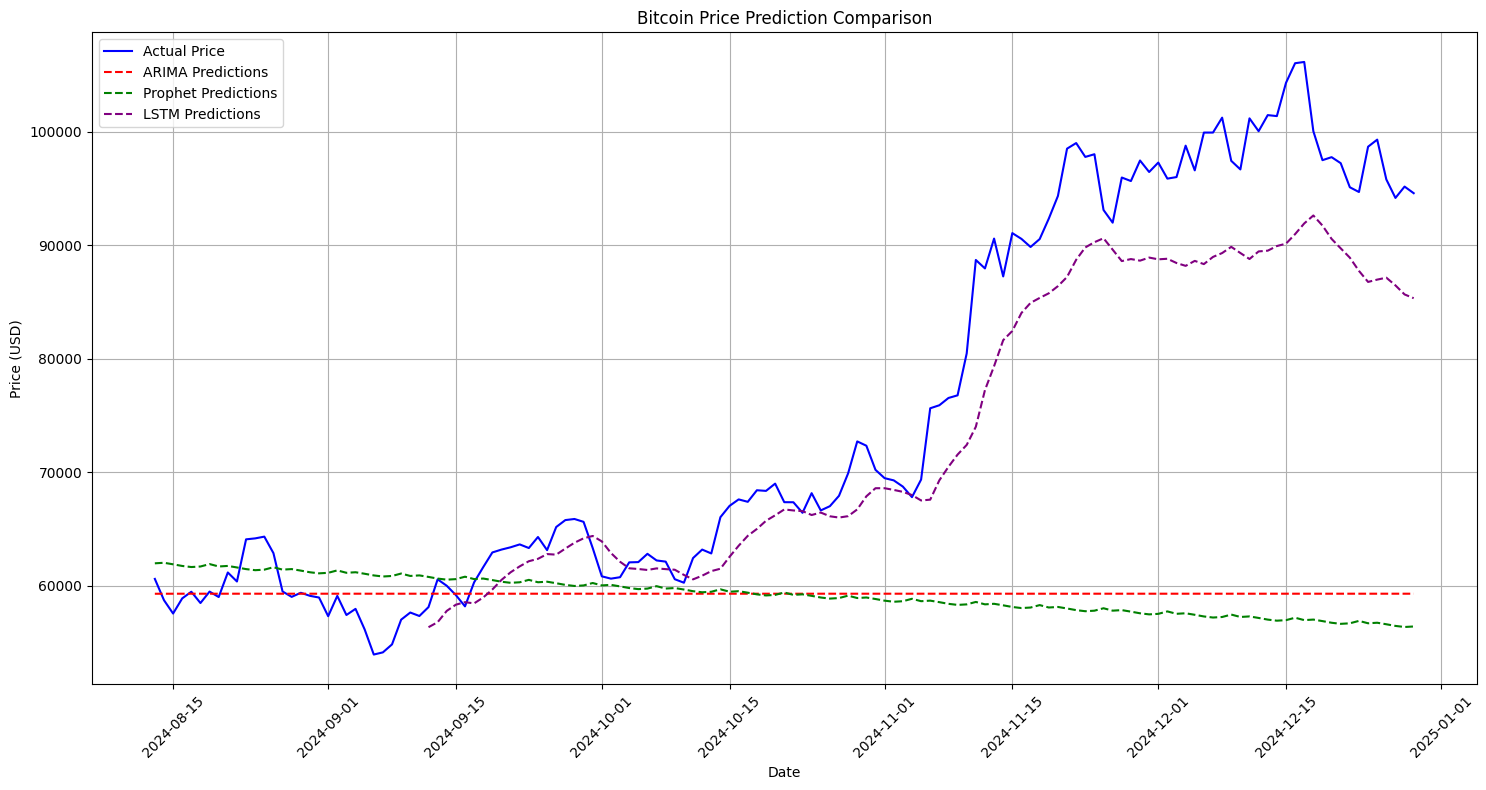

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from prophet import Prophet  # Updated import
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)

# Assuming final_df is already loaded and has 'Date' and 'Close' columns
data = final_df.copy()  # Use your final_df variable
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Feature Engineering: Add moving averages and technical indicators
data['7_day_MA'] = data['Close'].rolling(window=7).mean()
data['30_day_MA'] = data['Close'].rolling(window=30).mean()
data['Price_Change'] = data['Close'].pct_change()
data.fillna(0, inplace=True)

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['Close', '7_day_MA', '30_day_MA', 'Price_Change']])

# Split data into train and test
train_size = int(len(data) * 0.8)
train, test = data_scaled[:train_size], data_scaled[train_size:]

# Prepare data for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, 0])  # Predict 'Close' price
    return np.array(X), np.array(y)

time_step = 30
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

# Build LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

lstm_model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Make predictions with LSTM
train_predict = lstm_model.predict(X_train)
test_predict = lstm_model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((len(train_predict), 3))), axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((len(test_predict), 3))), axis=1))[:, 0]
y_train_actual = scaler.inverse_transform(train)[time_step:, 0]
y_test_actual = scaler.inverse_transform(test)[time_step:, 0]

# Evaluate LSTM model
def evaluate_model(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return rmse, mae, mape

lstm_rmse, lstm_mae, lstm_mape = evaluate_model(y_test_actual, test_predict)
logging.info(f"LSTM Model - RMSE: {lstm_rmse:.2f}, MAE: {lstm_mae:.2f}, MAPE: {lstm_mape:.2f}%")

# ARIMA Model
def train_arima(train_data):
    auto_model = auto_arima(train_data, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
    model = ARIMA(train_data, order=auto_model.order)
    fitted_model = model.fit()
    return fitted_model

arima_model = train_arima(data['Close'][:train_size])
arima_predict = arima_model.predict(start=train_size, end=len(data) - 1)
arima_rmse, arima_mae, arima_mape = evaluate_model(data['Close'][train_size:], arima_predict)
logging.info(f"ARIMA Model - RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}, MAPE: {arima_mape:.2f}%")

# Prophet Model
def train_prophet(train_data):
    prophet_data = train_data.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
    model = Prophet()
    model.fit(prophet_data)
    return model

prophet_model = train_prophet(data.iloc[:train_size])
future = prophet_model.make_future_dataframe(periods=len(data) - train_size)
prophet_forecast = prophet_model.predict(future)
prophet_predict = prophet_forecast['yhat'][-len(test):]
prophet_rmse, prophet_mae, prophet_mape = evaluate_model(data['Close'][train_size:], prophet_predict)
logging.info(f"Prophet Model - RMSE: {prophet_rmse:.2f}, MAE: {prophet_mae:.2f}, MAPE: {prophet_mape:.2f}%")

# Plot results
plt.figure(figsize=(15, 8))
plt.plot(data.index[train_size:], data['Close'][train_size:], label='Actual Price', color='blue')
plt.plot(data.index[train_size:], arima_predict, label='ARIMA Predictions', color='red', linestyle='--')
plt.plot(data.index[train_size:], prophet_predict, label='Prophet Predictions', color='green', linestyle='--')
plt.plot(data.index[train_size + time_step:], test_predict, label='LSTM Predictions', color='purple', linestyle='--')
plt.title('Bitcoin Price Prediction Comparison')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0490
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0074
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0029
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0018
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0014
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0013
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0013
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0011
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0011
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 7.6508e-04
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 6.6512e-04
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 5.9116e-04
Epoch 13/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 6.5923e-04
Epoch 14/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 6.8723e-04
Epoch 15/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpemjs7yb9/mxrxhe_0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpemjs7yb9/kzlahqsc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads

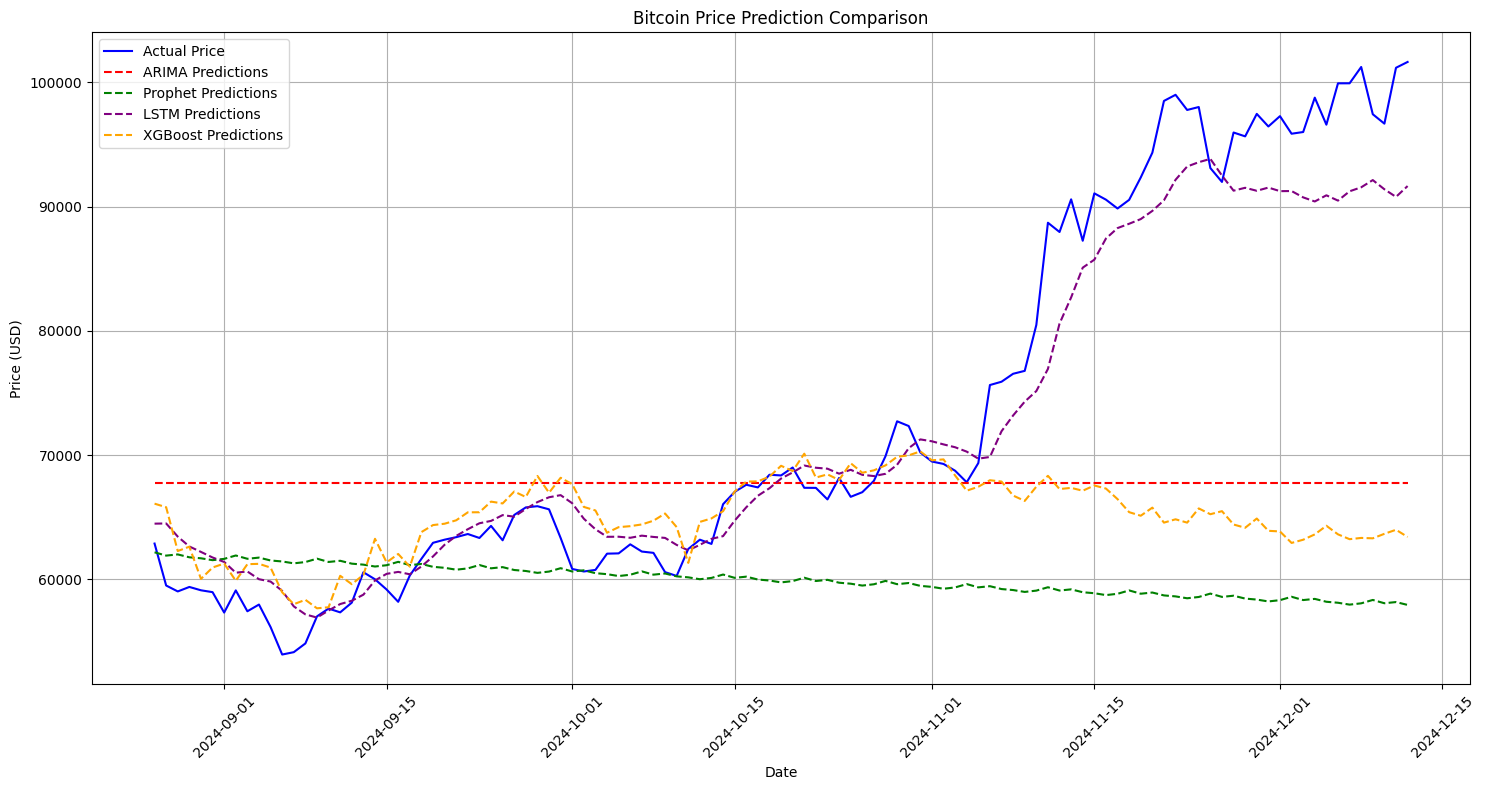

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from xgboost import XGBRegressor  # Dodano XGBoost
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)

# Assuming final_df is already loaded and has 'Date' and 'Close' columns
data = final_df.copy()  # Use your final_df variable
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Feature Engineering: Add moving averages and technical indicators
data['7_day_MA'] = data['Close'].rolling(window=7).mean()
data['30_day_MA'] = data['Close'].rolling(window=30).mean()
data['Price_Change'] = data['Close'].pct_change()
data.fillna(0, inplace=True)

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['Close', '7_day_MA', '30_day_MA', 'Price_Change']])

# Split data into train and test
train_size = int(len(data) * 0.8)
train, test = data_scaled[:train_size], data_scaled[train_size:]

# Prepare data for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, 0])  # Predict 'Close' price
    return np.array(X), np.array(y)

time_step = 30
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

# Build LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

lstm_model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Make predictions with LSTM
train_predict = lstm_model.predict(X_train)
test_predict = lstm_model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((len(train_predict), 3))), axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((len(test_predict), 3))), axis=1))[:, 0]
y_train_actual = scaler.inverse_transform(train)[time_step:, 0]
y_test_actual = scaler.inverse_transform(test)[time_step:, 0]

# Evaluate LSTM model
def evaluate_model(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return rmse, mae, mape

lstm_rmse, lstm_mae, lstm_mape = evaluate_model(y_test_actual, test_predict)
logging.info(f"LSTM Model - RMSE: {lstm_rmse:.2f}, MAE: {lstm_mae:.2f}, MAPE: {lstm_mape:.2f}%")

# ARIMA Model
def train_arima(train_data):
    auto_model = auto_arima(train_data, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
    model = ARIMA(train_data, order=auto_model.order)
    fitted_model = model.fit()
    return fitted_model

arima_model = train_arima(data['Close'][:train_size])
arima_predict = arima_model.predict(start=train_size, end=len(data) - 1)
arima_rmse, arima_mae, arima_mape = evaluate_model(data['Close'][train_size:], arima_predict)
logging.info(f"ARIMA Model - RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}, MAPE: {arima_mape:.2f}%")

# Prophet Model
def train_prophet(train_data):
    prophet_data = train_data.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
    model = Prophet()
    model.fit(prophet_data)
    return model

prophet_model = train_prophet(data.iloc[:train_size])
future = prophet_model.make_future_dataframe(periods=len(data) - train_size)
prophet_forecast = prophet_model.predict(future)
prophet_predict = prophet_forecast['yhat'][-len(test):]
prophet_rmse, prophet_mae, prophet_mape = evaluate_model(data['Close'][train_size:], prophet_predict)
logging.info(f"Prophet Model - RMSE: {prophet_rmse:.2f}, MAE: {prophet_mae:.2f}, MAPE: {prophet_mape:.2f}%")

# XGBoost Model
def train_xgboost(X_train, y_train, X_test):
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    return model.predict(X_test)

# Prepare data for XGBoost
X_train_xgb = X_train.reshape(X_train.shape[0], -1)
X_test_xgb = X_test.reshape(X_test.shape[0], -1)

# Train and predict with XGBoost
xgboost_predict = train_xgboost(X_train_xgb, y_train, X_test_xgb)
xgboost_predict = scaler.inverse_transform(np.concatenate((xgboost_predict.reshape(-1, 1), np.zeros((len(xgboost_predict), 3))), axis=1))[:, 0]
xgboost_rmse, xgboost_mae, xgboost_mape = evaluate_model(y_test_actual, xgboost_predict)
logging.info(f"XGBoost Model - RMSE: {xgboost_rmse:.2f}, MAE: {xgboost_mae:.2f}, MAPE: {xgboost_mape:.2f}%")

# Plot results
plt.figure(figsize=(15, 8))
plt.plot(data.index[train_size + time_step:], data['Close'][train_size + time_step:], label='Actual Price', color='blue')
plt.plot(data.index[train_size + time_step:], arima_predict[time_step:], label='ARIMA Predictions', color='red', linestyle='--')
plt.plot(data.index[train_size + time_step:], prophet_predict[time_step:], label='Prophet Predictions', color='green', linestyle='--')
plt.plot(data.index[train_size + time_step:], test_predict, label='LSTM Predictions', color='purple', linestyle='--')
plt.plot(data.index[train_size + time_step:], xgboost_predict, label='XGBoost Predictions', color='orange', linestyle='--')
plt.title('Bitcoin Price Prediction Comparison')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()